In [1]:
%matplotlib inline
%pylab inline

import math
import random
import numpy as np
import pandas as pd
from sklearn import dummy, metrics, cross_validation, ensemble

import keras.models as kmodels
import keras.layers as klayers
import keras.backend as K
import keras

data = pd.read_csv("./steam-200k.csv", header=None, index_col=None, names=['uID', 'game', 'action', 'hours','other'])
data.head()

Populating the interactive namespace from numpy and matplotlib


/home/pawel/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


,uID,game,action,hours,other
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [2]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = 1+ (df[feature_name] - min_value)* 9 / (max_value - min_value)
    return result

playData = data[data.action=='play']

playData[['game']] = playData[['game']].stack().rank(method='dense').unstack()

user_item_matrix = pd.pivot_table(playData, index = 'uID', columns ='game', values = 'hours',fill_value= 0)
user_item_matrix = normalize(user_item_matrix)

user_item_matrix = user_item_matrix.reset_index().melt(id_vars='uID',value_name='hours')
playData = user_item_matrix.ix[~(user_item_matrix['hours'] == 1.0)]
playData[['uID']] = playData[['uID']].stack().rank(method='dense').unstack()

playData.sort_values(['uID'])
playData['hours'].describe()

/home/pawel/.local/lib/python3.5/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/pawel/.local/lib/python3.5/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/pawel/.local/lib/python3.5/site-packages/pandas/core/

count    70477.000000
mean         2.249506
std          2.289660
min          1.000077
25%          1.039051
50%          1.251163
75%          2.154076
max         10.000000
Name: hours, dtype: float64

In [3]:
game_count = len(playData['game'].unique())
user_count = len(playData['uID'].unique())

gameid = playData['game'].values
userid = playData['uID'].values

y = np.zeros((playData.shape[0], 10))
y[np.arange(playData.values.shape[0]), playData['hours'].values.astype(int) -1] = 1
y

array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.]])

In [4]:
#deep learning classifier

#vectorizing games
game_input = keras.layers.Input(shape=[1])
game_vec = keras.layers.Flatten()(keras.layers.Embedding(game_count + 1, 32)(game_input))
game_vec = keras.layers.Dropout(0.5)(game_vec)

# vectorizing users
user_input = keras.layers.Input(shape=[1])
user_vec = keras.layers.Flatten()(keras.layers.Embedding(user_count + 1, 32)(user_input))
user_vec = keras.layers.Dropout(0.5)(user_vec)

# Join users ang games together put through a deep learning architecture
input_vecs = keras.layers.merge([game_vec, user_vec], mode='concat')
nn = keras.layers.Dropout(0.5)(keras.layers.Dense(64, activation='tanh')(input_vecs))
nn = keras.layers.normalization.BatchNormalization()(nn)
nn = keras.layers.Dropout(0.5)(keras.layers.Dense(64, activation='tanh')(nn))
nn = keras.layers.normalization.BatchNormalization()(nn)
nn = keras.layers.Dense(64, activation='tanh')(nn)

# Result output
result = keras.layers.Dense(10, activation='softmax')(nn)

# And make a runable model from it
model = kmodels.Model([game_input, user_input], result)
model.compile('adam', 'categorical_crossentropy')

final_layer = kmodels.Model([game_input, user_input], nn)
game_vec = kmodels.Model(game_input, game_vec)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  
/usr/local/lib/python3.5/dist-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [5]:
a_gameid, b_gameid, a_userid, b_userid, a_y, b_y = cross_validation.train_test_split(gameid, userid, y)

In [6]:
metrics.mean_absolute_error(np.argmax(b_y, 1)+1, np.argmax(model.predict([b_gameid, b_userid]), 1)+1)

3.9890465380249718

In [7]:
sqrt(metrics.mean_squared_error(   
    np.argmax(b_y, 1)+1, 
    np.argmax(model.predict([b_gameid, b_userid]), 1)+1))


4.8594957768731888

Train on 52857 samples, validate on 17620 samples
Epoch 1/5
52857/52857 [==============================] - 13s 249us/step - loss: 1.1199 - val_loss: 0.9457
Epoch 2/5
52857/52857 [==============================] - 13s 239us/step - loss: 0.9555 - val_loss: 0.9357
Epoch 3/5
52857/52857 [==============================] - 11s 214us/step - loss: 0.9180 - val_loss: 0.9293
Epoch 4/5
52857/52857 [==============================] - 12s 226us/step - loss: 0.8908 - val_loss: 0.9278
Epoch 5/5
52857/52857 [==============================] - 11s 216us/step - loss: 0.8691 - val_loss: 0.9428


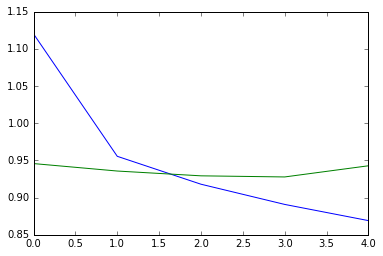

In [8]:
try:
    history = model.fit([a_gameid, a_userid], a_y, 
                         epochs=5, 
                         validation_data=([b_gameid, b_userid], b_y),
                       )
    plot(history.history['loss'])
    plot(history.history['val_loss'])
except KeyboardInterrupt:
    pass

In [9]:
metrics.mean_absolute_error(
    np.argmax(b_y, 1)+1, 
    np.argmax(model.predict([b_gameid, b_userid]), 1)+1)

1.0182746878547106

In [10]:
sqrt(metrics.mean_squared_error(   
    np.argmax(b_y, 1)+1, 
    np.argmax(model.predict([b_gameid, b_userid]), 1)+1))


2.5183999388473586